### Danger Level Forecasting Preliminary Models

Testing out some of the classification models

#### Import Tools

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, \
    precision_recall_curve, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

#### Import Data

In [2]:
avi = pd.read_csv('SnowWeatherCleanROS.csv')
avi.head()

,Unnamed: 0,avi_danger,avg_wind,temp_max_swing,temp_max_swing_from_avg,year,month,day,temp_max,temp_min,...,prevailing_wind_E_2,prevailing_wind_N_2,prevailing_wind_NE_2,prevailing_wind_NW_2,prevailing_wind_S_2,prevailing_wind_SE_2,prevailing_wind_SW_2,prevailing_wind_W_2,three_day_snow_2,next_day_avi_danger
0,0,1.0,20.58,0.0,0.0,2010.0,12.0,20.0,15,5,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.2,3.0
1,1,3.0,35.12,3.0,0.0,2010.0,12.0,21.0,18,10,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.3,2.0
2,2,2.0,33.78,-3.0,0.0,2010.0,12.0,22.0,15,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,3.0
3,3,3.0,31.32,0.0,0.0,2010.0,12.0,23.0,15,6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.3,2.0
4,4,2.0,32.44,2.0,1.4,2010.0,12.0,24.0,17,9,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.3,2.0


#### filter data

In [3]:
avi = avi.drop(['Unnamed: 0'], axis=1)

In [4]:
avi = avi[avi['avi_danger'].notnull()]
avi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1892 entries, 0 to 1891
Data columns (total 72 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   avi_danger                 1892 non-null   float64
 1   avg_wind                   1892 non-null   float64
 2   temp_max_swing             1892 non-null   float64
 3   temp_max_swing_from_avg    1892 non-null   float64
 4   year                       1892 non-null   float64
 5   month                      1892 non-null   float64
 6   day                        1892 non-null   float64
 7   temp_max                   1892 non-null   int64  
 8   temp_min                   1892 non-null   int64  
 9   water_equivalent           1892 non-null   float64
 10  snow_fall                  1892 non-null   float64
 11  snow_depth_6am             1892 non-null   float64
 12  wind_speed_sum             1892 non-null   int64  
 13  sunshine_percent           1892 non-null   int64

#### Fill Remaing NA's

In [5]:
avi = avi.fillna(0)
avi = avi[avi.avi_danger != 5]
avi = avi[avi.next_day_avi_danger != 5]
avi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1892 entries, 0 to 1891
Data columns (total 72 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   avi_danger                 1892 non-null   float64
 1   avg_wind                   1892 non-null   float64
 2   temp_max_swing             1892 non-null   float64
 3   temp_max_swing_from_avg    1892 non-null   float64
 4   year                       1892 non-null   float64
 5   month                      1892 non-null   float64
 6   day                        1892 non-null   float64
 7   temp_max                   1892 non-null   int64  
 8   temp_min                   1892 non-null   int64  
 9   water_equivalent           1892 non-null   float64
 10  snow_fall                  1892 non-null   float64
 11  snow_depth_6am             1892 non-null   float64
 12  wind_speed_sum             1892 non-null   int64  
 13  sunshine_percent           1892 non-null   int64

#### Splitting Dataset

In [6]:
x = avi.iloc[:, 0:avi.shape[1]-2]
y = avi.iloc[:, avi.shape[1]-1]

print(x.shape)
print(y.shape)

(1892, 70)
(1892,)


#### Standardizing

In [7]:
#standardizer 
def standardize(X_train, X_test):
    scaler = StandardScaler()
    # Fitting and transforming training data
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    # Tranforming testing data based on traning fit (prevent data leakage)
    X_test = scaler.transform(X_test)
    return X_train, X_test

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Scaling
x_train, x_test = standardize(x_train, x_test)

In [9]:
print(y)

(unique, counts) = np.unique(y, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)


0       3.0
1       2.0
2       3.0
3       2.0
4       2.0
       ... 
1887    4.0
1888    4.0
1889    4.0
1890    4.0
1891    4.0
Name: next_day_avi_danger, Length: 1892, dtype: float64
[[  1. 473.]
 [  2. 473.]
 [  3. 473.]
 [  4. 473.]]


### Decision Trees 

In [10]:
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }


ds = DecisionTreeClassifier()
ds_cv = RandomizedSearchCV(estimator=ds, param_distributions=random_grid, n_iter=100, scoring='f1_weighted')
ds_cv.fit(x_train, y_train)
y_pred_ds = ds_cv.predict(x_test)
print(accuracy_score(y_test, y_pred_ds))
print(cross_val_score(ds, x_train, y_train, cv=3))

0.7505285412262156
[0.68710359 0.70401691 0.7167019 ]


In [11]:
print(confusion_matrix(y_test, y_pred_ds))

[[ 91  14  16   2]
 [ 11  61  26   4]
 [ 12  27  90   6]
 [  0   0   0 113]]


In [12]:
print(classification_report(y_test, y_pred_ds))

              precision    recall  f1-score   support

         1.0       0.80      0.74      0.77       123
         2.0       0.60      0.60      0.60       102
         3.0       0.68      0.67      0.67       135
         4.0       0.90      1.00      0.95       113

    accuracy                           0.75       473
   macro avg       0.75      0.75      0.75       473
weighted avg       0.75      0.75      0.75       473



### Random Forest

In [13]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf = RandomForestClassifier(class_weight = "balanced")
rf.fit(x_train, y_train)
rf_cv = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=5, scoring='f1_weighted')
rf_cv.fit(x_train, y_train)
y_pred_rf = rf_cv.predict(x_test)
print(accuracy_score(y_test, y_pred_rf))
print(cross_val_score(rf, x_train, y_train, cv=3))

0.7906976744186046
[0.75475687 0.76109937 0.78435518]


In [14]:
print(confusion_matrix(y_test, y_pred_rf))

[[101  21   1   0]
 [  7  76  19   0]
 [  8  41  84   2]
 [  0   0   0 113]]


In [15]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         1.0       0.87      0.82      0.85       123
         2.0       0.55      0.75      0.63       102
         3.0       0.81      0.62      0.70       135
         4.0       0.98      1.00      0.99       113

    accuracy                           0.79       473
   macro avg       0.80      0.80      0.79       473
weighted avg       0.81      0.79      0.79       473



## Find Feature Importances

Text(0.5, 0, 'Random Forest Feature Importance')

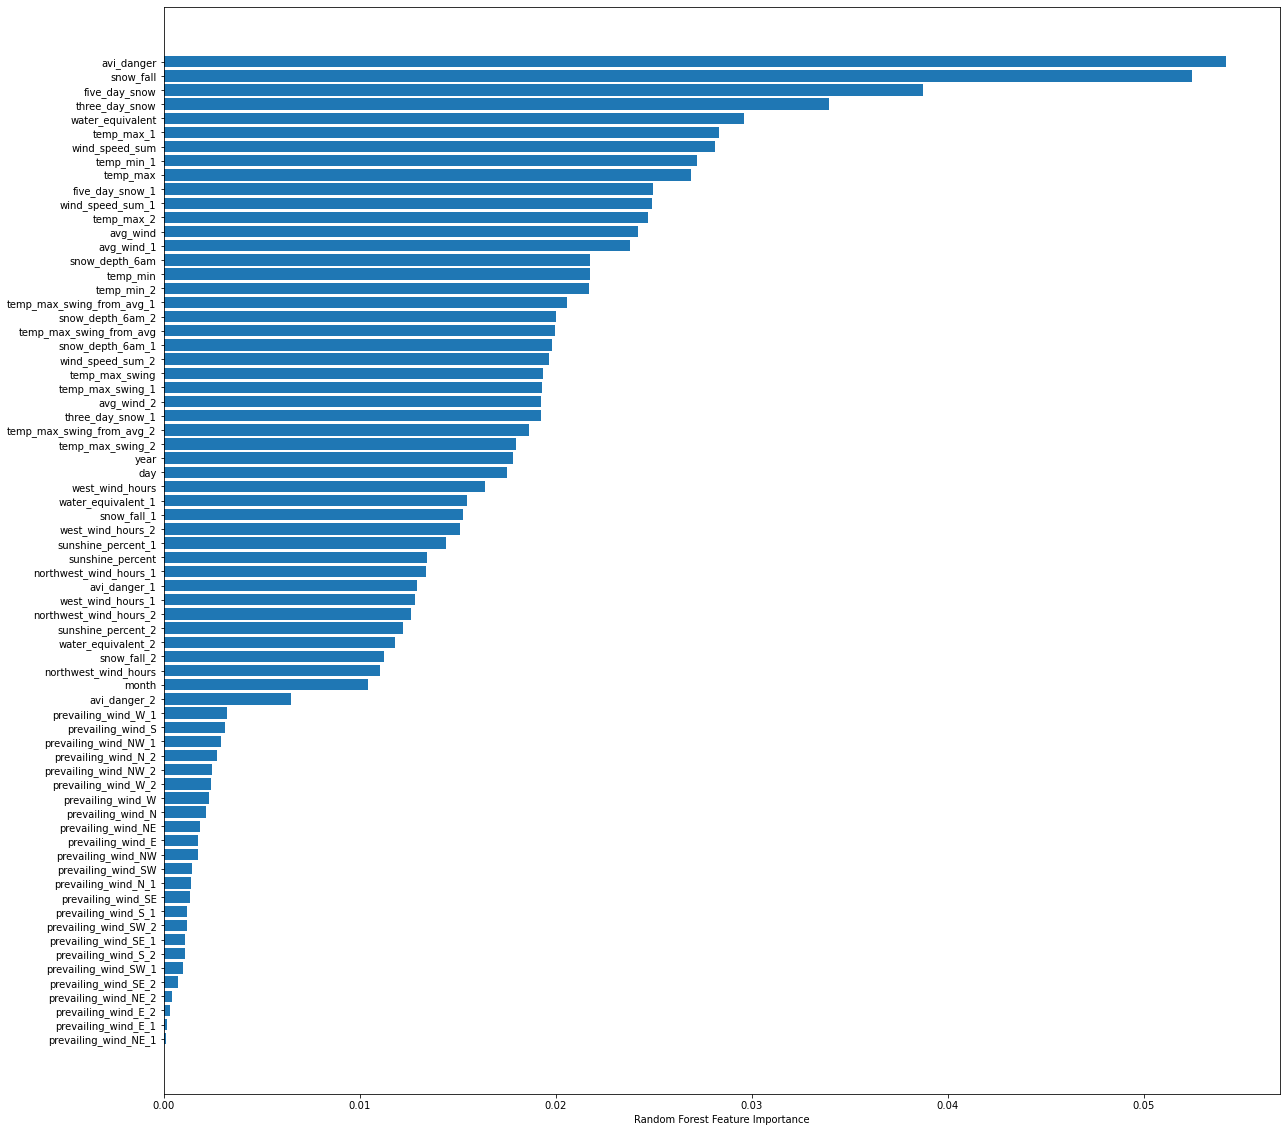

In [16]:
sorted_idx = rf.feature_importances_.argsort()
plt.figure(figsize=[20,20])
plt.barh(avi.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Extra Forest

In [17]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

et = ExtraTreesClassifier(class_weight = "balanced")
et_cv = RandomizedSearchCV(estimator=et, param_distributions=random_grid, n_iter=5, scoring='f1_weighted')
et_cv.fit(x_train, y_train)
y_pred_et = et_cv.predict(x_test)
print(accuracy_score(y_test, y_pred_et))
print(cross_val_score(rf, x_train, y_train, cv=3))

0.7949260042283298
[0.75687104 0.74630021 0.79704017]


In [18]:
print(confusion_matrix(y_test, y_pred_et))

[[100  22   1   0]
 [  9  72  21   0]
 [  9  33  91   2]
 [  0   0   0 113]]


In [19]:
print(classification_report(y_test, y_pred_et))

              precision    recall  f1-score   support

         1.0       0.85      0.81      0.83       123
         2.0       0.57      0.71      0.63       102
         3.0       0.81      0.67      0.73       135
         4.0       0.98      1.00      0.99       113

    accuracy                           0.79       473
   macro avg       0.80      0.80      0.80       473
weighted avg       0.81      0.79      0.80       473

